In [2]:
import numpy as np 
import pandas as pd 
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [3]:
from keras.models import load_model
from pygame import mixer
import time

pygame 2.1.2 (SDL 2.0.18, Python 3.9.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


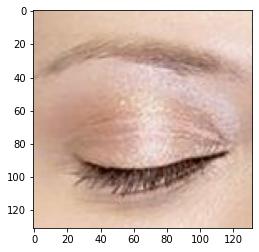

In [4]:
a= plt.imread("C:\\Users\\Aastha\\Desktop\\DrowsyDriverDetection-master\\train\\Closed\\_2.jpg")
plt.imshow(a)

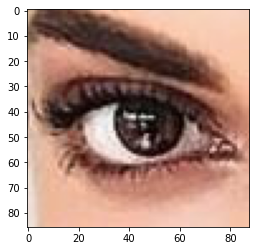

In [5]:
b= plt.imread("C:\\Users\\Aastha\\Desktop\\DrowsyDriverDetection-master\\train\\Open\\_1.jpg")
plt.imshow(b)

In [6]:
a.shape

(131, 132, 3)

In [7]:
b.shape


(86, 88, 3)

In [8]:
l_cascade= cv2.CascadeClassifier("C:\\Users\\Aastha\\Desktop\\archive\\Drowsiness detection\\haar cascade files\\haarcascade_lefteye_2splits.xml")

In [9]:
r_cascade= cv2.CascadeClassifier("C:\\Users\\Aastha\\Desktop\\archive\\Drowsiness detection\\haar cascade files\\haarcascade_righteye_2splits.xml")

In [10]:
face=cv2.CascadeClassifier("C:\\Users\\Aastha\\Desktop\\train\\haar cascade files\\haarcascade_frontalface_alt.xml")

### reading a yawn image


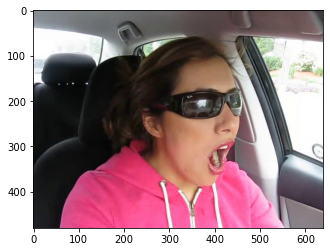

In [11]:
b= plt.imread("C:\\Users\\Aastha\\Desktop\\DrowsyDriverDetection-master\\train\\yawn\\282.jpg")
plt.imshow(b)

In [12]:
b.shape

(480, 640, 3)

### reading a no yawn image

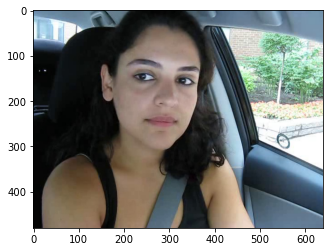

In [13]:
c= plt.imread("C:\\Users\\Aastha\\Desktop\\DrowsyDriverDetection-master\\train\\no_yawn\\54.jpg")
plt.imshow(c)

In [14]:
def face_for_yawn(direc="C:\\Users\\Aastha\\Desktop\\DrowsyDriverDetection-master\\train", face_cas_path="C:\\Users\\Aastha\\Desktop\\DrowsyDriverDetection-master\\Haar\\haarcascade_frontalface_default.xml"):
    yaw_no = []
    IMG_SIZE = 145
    categories = ["yawn", "no_yawn"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                yaw_no.append([resized_array, class_num1])
    return yaw_no


yawn_no_yawn = face_for_yawn()

0
1


In [15]:
def get_data(dir_path="C:\\Users\\Aastha\\Desktop\\DrowsyDriverDetection-master\\train", face_cas= "C:\\Users\\Aastha\\Desktop\\DrowsyDriverDetection-master\\Haar\\haarcascade_frontalface_default.xml"):
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        class_num +=2
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data
data_train = get_data()

2
3


In [16]:
def append_data():
    yaw_no = face_for_yawn()
    data = get_data()
    yaw_no.extend(data)
    return np.array(yaw_no)

In [17]:
new_data = append_data()

0
1
2
3


C:\Users\Aastha\AppData\Local\Temp\ipykernel_1596\3548787232.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(yaw_no)


### separate label and features

In [18]:
X = []
y = []
for feature, label in new_data:
    X.append(feature)
    y.append(label)

In [19]:
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

In [20]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

In [21]:
y = np.array(y)

In [22]:
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

In [23]:
len(X_test)

578

In [24]:
y_test

array([[0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       ...,
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       [0, 0, 1, 0]])

In [25]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

In [26]:
model = Sequential()

model.add(Conv2D(256, (3, 3), activation="relu", input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))

model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

model.summary()
Model: "sequential"

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 143, 143, 256)     7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 71, 71, 256)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 34, 34, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0

In [27]:
history = model.fit(train_generator, epochs=10, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))

Epoch 1/10
43/43 [==============================] - 10993s 261s/step - loss: 1.1098 - accuracy: 0.5286 - val_loss: 0.5173 - val_accuracy: 0.7526
Epoch 2/10
43/43 [==============================] - 21470s 511s/step - loss: 0.4972 - accuracy: 0.7921 - val_loss: 0.3723 - val_accuracy: 0.7993
Epoch 3/10
43/43 [==============================] - 226s 5s/step - loss: 0.3784 - accuracy: 0.8315 - val_loss: 0.3192 - val_accuracy: 0.8253
Epoch 4/10
43/43 [==============================] - 209s 5s/step - loss: 0.3496 - accuracy: 0.8604 - val_loss: 0.2872 - val_accuracy: 0.8651
Epoch 5/10
43/43 [==============================] - 202s 5s/step - loss: 0.3083 - accuracy: 0.8686 - val_loss: 0.2668 - val_accuracy: 0.8927
Epoch 6/10
43/43 [==============================] - 187s 4s/step - loss: 0.3315 - accuracy: 0.8693 - val_loss: 0.2492 - val_accuracy: 0.8858
Epoch 7/10
43/43 [==============================] - 179s 4s/step - loss: 0.2934 - accuracy: 0.8753 - val_loss: 0.2362 - val_accuracy: 0.9152
Epoch

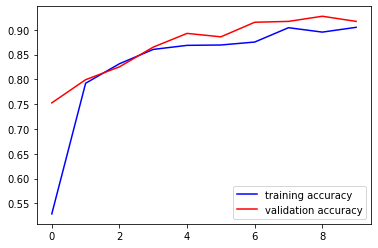

In [28]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="training accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()


In [29]:
model.save("drowiness.h5")
model.save("drowiness.model")

INFO:tensorflow:Assets written to: drowiness.model\assets


INFO:tensorflow:Assets written to: drowiness.model\assets


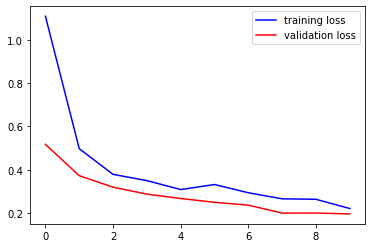

In [30]:
plt.plot(epochs, loss, "b", label="training loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

In [31]:
prediction = model.predict(X_test)


19/19 [==============================] - 19s 967ms/step


In [32]:
prediction=prediction.reshape(-1,1)

In [33]:
prediction.shape

(2312, 1)

In [34]:
type(prediction)

numpy.ndarray

In [35]:
n_values = np.max(prediction) + 1
n_values = n_values.astype(int)

In [36]:
pred = np.eye(n_values)[prediction.astype(int)]
pred

array([[[1., 0.]],

       [[1., 0.]],

       [[1., 0.]],

       ...,

       [[1., 0.]],

       [[0., 1.]],

       [[1., 0.]]])

In [37]:
print(y_test.shape)
print(prediction.shape)
prediction=np.reshape(prediction, (578*1, 4))


(578, 4)
(2312, 1)


In [38]:
prediction

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], dtype=float32)

# Classification report

In [39]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]

In [59]:
#from sklearn.metrics import classification_report
#print(classification_report(np.argmax(y_test,axis= 1), prediction, target_names=labels_new))
#classification_report( np.argmax(y_test, axis=1),pred,target_names=labels_new)


In [60]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]
IMG_SIZE = 145
def prepare(filepath, face_cas="../input/prediction-images/haarcascade_frontalface_default.xml"):
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
    img_array = img_array / 255
    resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

model = tf.keras.models.load_model("drowiness.model")

### Prediction
0 - yawn 
1 - no_yawn 
2 - Closed
3 - Open

In [61]:
# prepare("../input/drowsiness-dataset/train/no_yawn/1068.jpg")
prediction = model.predict([prepare("C:\\Users\\Aastha\\Desktop\\DrowsyDriverDetection-master\\train\\Open\\_28.jpg")])
np.argmax(prediction)

1/1 [==============================] - 0s 412ms/step


3

In [62]:
prediction = model.predict([prepare("C:\\Users\\Aastha\\Desktop\\DrowsyDriverDetection-master\\train\\yawn\\52.jpg")])
np.argmax(prediction)

1/1 [==============================] - 0s 78ms/step


2

In [63]:
#prediction = model.predict([prepare("../input/drowsiness-dataset/train/Open/_104.jpg")])
#np.argmax(prediction)

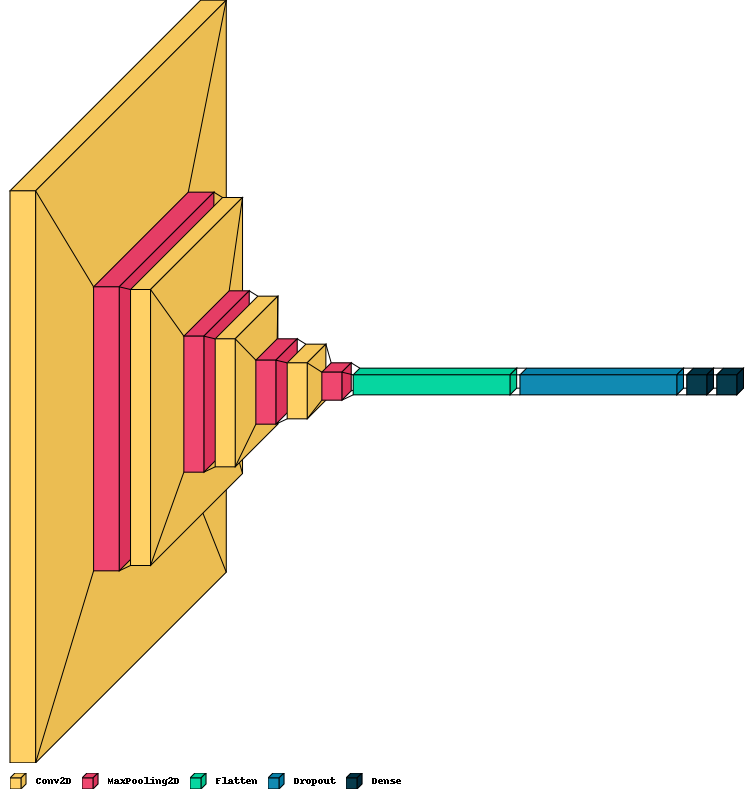

In [54]:
!pip install visualkeras
import visualkeras

visualkeras.layered_view(model).show() # display using your system viewer
visualkeras.layered_view(model, to_file='output.png') # write to disk
visualkeras.layered_view(model, to_file='output.png').show() # write and show

visualkeras.layered_view(model,legend=True)